# Project aim

The aim of the project is to assess the performance of an UNet or any other Deep model for cell segmentation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torchviz import make_dot
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
from skimage.io import imread,imshow, imsave
from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import random

In [2]:
TRAIN_PATH = 'dataset/stage1_train/'

train_files = next(os.walk(TRAIN_PATH))[1]

X_train = np.zeros((len(train_files), 128, 128, 3), dtype = np.uint8)
Y_train = np.zeros((len(train_files), 128, 128, 1))

img_height = 256
img_width = 256
img_channel = 3

In [3]:
def preprocess(id_, path):
    """
    input: list of ids, path of directory
    output: return X_train and y_train
    """
    
    # initialize two empty array to store
    # size is (# of training instance, img_size, img_size, img_channel)
    X_train = np.zeros((len(id_), img_height, img_width, img_channel), dtype = np.uint8)
    Y_train = np.zeros((len(id_), img_height, img_width, 1))
    
    # iterate through all the training img, save each training instance into X_train
    # using tqdm is good for us to visualize the process
    for n, id_ in tqdm(enumerate(id_), total = len(id_)):   
        cur_path = path + id_
        # read in img as array
        img = imread(cur_path + '/images/' + id_ + '.png')[:,:,:img_channel]  
        # resize data to increase the speed of training
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        # save current img into X_train
        X_train[n] = img  
        # for each img, we have several masks
        # we need to iterate through each one 
        mask = np.zeros((img_height, img_width, 1))
        for mask_file in os.listdir(cur_path + '/masks/'):
            # read in current mask
            cur_mask = imread(cur_path + '/masks/' + mask_file)
            # resize it and adjust the dimension to 128x128x1
            cur_mask = np.expand_dims(resize(cur_mask, (img_height, img_width), mode = 'constant', preserve_range = True), axis = -1)
            mask = np.maximum(mask, cur_mask)
            #save the mask in a folder called labels at the same height of masks
            #Image.fromarray(mask).save(cur_path + '/labels/' + id_ + '.png')


        Y_train[n] = mask
    return X_train, Y_train



In [4]:
X_train, Y_train = preprocess(train_files, TRAIN_PATH)

100%|██████████| 670/670 [05:05<00:00,  2.19it/s]


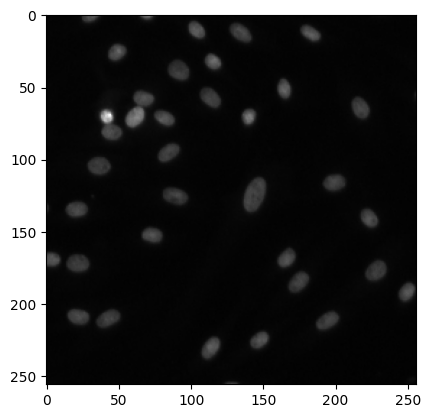

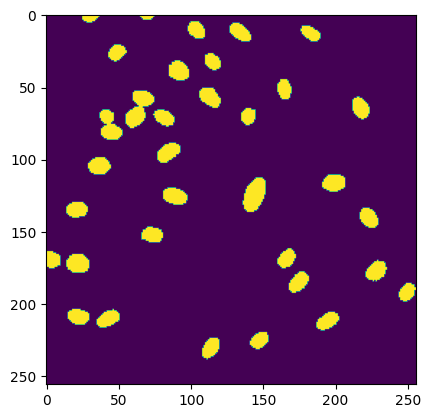

In [5]:
plt.imshow(X_train[1])
plt.show()
plt.imshow(np.squeeze(Y_train[1]))
plt.show()

In [6]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class double_convolution(nn.Module):
    """
    This class implements the double convolution block which consists of two 3X3 convolution layers,
    each followed by a ReLU activation function.

    """
    def __init__(self, in_channels, out_channels): # Initialize the class
        super().__init__() # Initialize the parent class

        # First 3X3 convolution layer
        self.first_cnn = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act1 = nn.ReLU()

        # Second 3X3 convolution layer
        self.second_cnn = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act2 = nn.ReLU()

    # Pass the input through the double convolution block
    def forward(self, x):
        x = self.first_cnn(x)
        x = self.act1(x)
        x = self.act2(self.second_cnn(x))
        return x
    
class triple_convolution(nn.Module):
    """
    This class implements the triple convolution block which consists of three 3X3 convolution layers,
    each followed by a ReLU activation function.

    """
    def __init__(self, in_channels, out_channels): # Initialize the class
        super().__init__() # Initialize the parent class

        # First 3X3 convolution layer
        self.first_cnn = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        # Second 3X3 convolution layer
        self.second_cnn = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        # Third 3X3 convolution layer
        self.third_cnn = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

    # Pass the input through the triple convolution block
    def forward(self, x):
        x = self.first_cnn(x)
        x = self.act1(x)
        x = self.second_cnn(x)
        x = self.act2(x)
        x = self.third_cnn(x)
        x = self.act3(x)
        return x

# Implement the Downsample block that occurs after each double convolution block
class down_sample(nn.Module):
    """
    This class implements the downsample block which consists of a Max Pooling layer with a kernel size of 2.
    The Max Pooling layer halves the image size reducing the spatial resolution of the feature maps
    while retaining the most important features.
    """
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x
    
# Implement the UpSample block that occurs in the decoder part of the network
class up_sample(nn.Module):
    """
    This class implements the upsample block which consists of a convolution transpose layer with a kernel size of 2.
    The convolution transpose layer doubles the image size increasing the spatial resolution of the feature maps
    while retaining the learned features.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer
        self.up_sample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x 

# Implement the crop and concatenate block that occurs in the decoder part of the network
# This block concatenates the output of the upsample block with the output of the corresponding downsample block
# The output of the crop and concatenate block is then passed through a double convolution block
class crop_and_concatenate(nn.Module):
    """
    This class implements the crop and concatenate block which combines the output of the upsample block
    with the corresponding features from the contracting path through skip connections,
    allowing the network to recover the fine-grained details lost during downsampling
    and produce a high-resolution output segmentation map.
    """ 
    # def forward(self, upsampled, bypass):
    #     # Crop the feature map from the contacting path to match the size of the upsampled feature map
    #     bypass = torchvision.transforms.functional.center_crop(img = bypass, output_size = [upsampled.shape[2], upsampled.shape[3]]) 
    #     # Concatenate the upsampled feature map with the cropped feature map from the contracting path
    #     x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
    #     return x
    # Alternatively crop the upsampled feature map to match the size of the feature map from the contracting path
    def forward(self, upsampled, bypass):
        upsampled = torchvision.transforms.functional.resize(img = upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# m = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
# input = torch.randn(1, 1024, 28, 28)
# m(input).shape 

# m = nn.MaxPool2d(kernel_size = 2, stride = 2)
# xx = torch.randn(1, 1, 143, 143)
# m(xx).shape

## Implement the UNet architecture
class UNet(nn.Module):
    # in_channels: number of channels in the input image
    # out_channels: number of channels in the output image
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Define the contracting path: convolution blocks followed by downsample blocks
        self.down_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, 64), (64, 128), (128, 256), (256, 512)]) # List of downsample blocks
        
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck layer
        self.bottleneck = double_convolution(in_channels = 512, out_channels = 1024)

        # Define the expanding path: upsample blocks followed by convolution blocks
        self.up_samples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of upsample blocks
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of convolution blocks
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv2d(in_channels = 64, out_channels = out_channels, kernel_size = 1)

    # Pass the input through the UNet architecture
    def forward(self, x):
        # Pass the input through the contacting path
        skip_connections = [] # List to store the outputs of the downsample blocks
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)
        
        # Pass the output of the contacting path through the bottleneck layer
        x = self.bottleneck(x)

        # Pass the output of the bottleneck layer through the expanding path
        skip_connections = skip_connections[::-1] # Reverse the list of skip connections
        for up_sample, concat, up_conv in zip(self.up_samples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, skip_connections.pop(0)) # Remove the first element from the list of skip connections
            x = up_conv(x)
        
        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x


In [7]:
model = UNet(in_channels = 3, out_channels = 1).to(device)

In [8]:
class CellularDataSet(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        #angle = random.uniform(-10, 10)
        #width, height = image.size
        #max_dx = 0.1 * width
        #max_dy = 0.1 * height
        #translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        #scale = random.uniform(0.8, 1.2)
        #shear = random.uniform(-0.5, 0.5)
        #image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        #mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask    

In [9]:
seed = 42
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = seed)

train_dataset = CellularDataSet(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)


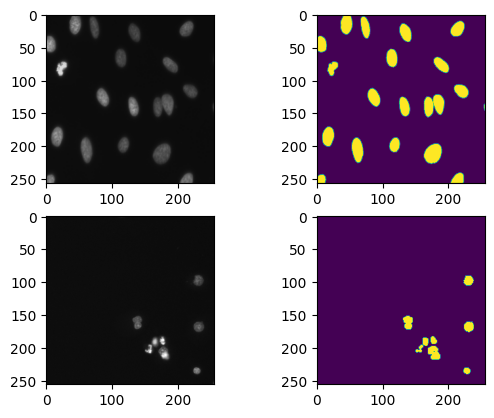

In [10]:
fig, axis = plt.subplots(2, 2)
axis[0][0].imshow(X_train[0].astype(np.uint8))
axis[0][1].imshow(np.squeeze(Y_train[0]).astype(np.uint8))
axis[1][0].imshow(X_val[0].astype(np.uint8))
axis[1][1].imshow(np.squeeze(Y_val[0]).astype(np.uint8))

In [11]:
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
      pred_inds = pred == cls
      target_inds = target == cls
      intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
      union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
    
      if union == 0:
        iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
      else:
        iou.append(float(intersection) / float(max(union, 1)))
     
    return sum(iou)

In [12]:
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

In [13]:
opt = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 3, verbose = 1)

c:\MiniConda\envs\deeplife\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
def fit(model, epochs, opt, loss_func, train_loader, alpha):

    for epoch in range(epochs):
        
        #Going into training mode
        model.train()
        
        train_loss = 0 
        iou = 0
        
        for image, mask in train_loader:
            image = image.to(device)   #Passing the input mini-batch to the GPU
            mask = mask.to(device)   #Passing the label mini-batch to the GPU
            opt.zero_grad()      #Setting the grads to zero to avoid accumulation of gradients
            out = model(image.float())
            loss = loss_func(out.float(), mask.float())  # RuntimeError: all elements of target should be between 0 and 1  <---------- FIX HERE
            train_loss += loss
            
            iou += iou_metric(out, mask)
            iou_rev = 16 - iou_metric(out, mask)
            loss += alpha * iou_rev
            
            loss.backward()
            opt.step()
        
        lr_scheduler.step(train_loss/len(train_loader))   #Setting up lr decay  
        
        model.eval()            #Going into eval mode                            
        #with torch.no_grad():   #No backprop
        #    valid_loss = 0
        #    valid_iou = 0
        #    
        #    for image_val, mask_val in valid_loader:
        #        image_val = image_val.to(device)  
        #        mask_val = mask_val.to(device)
        #        out_val = model(image_val.float())
        #        valid_loss += loss_func(out_val.float(), mask_val.float())
        #        
        #        valid_iou += iou_metric(out_val, mask_val)
        
        #print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "CV Loss: ", valid_loss/len(valid_loader))
        #print("Training IoU: ", iou/len(train_loader), "CV IoU: ", valid_iou/len(valid_loader))
        print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader))
        print("Training IoU: ", iou/len(train_loader))

In [15]:
fit(model, 30, opt, loss_func, train_loader, 5)

RuntimeError: all elements of target should be between 0 and 1